In [2]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

In [3]:
file = "questions.pkl"
fileobj = open(file, "rb")
problem = pickle.load(fileobj)
print(type(problem))

<class 'dict'>


In [22]:
x_train = problem['x_data'].iloc[:,:-1]
y_train = problem['y_data']

In [70]:
train_data = x_train.join(y_train)
train_data

,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,Channel 9,Channel 10,Sine_Feacyc_Week,Cosine_Feacyc_Week,Transactions
3,93.9909,670.77,227.6126,0.0000,670.15,96.984400,345.938308,70.350616,51.0,0.0,0.120476,0.992716,0.0
4,153.2981,746.61,219.0309,0.0000,745.89,324.223378,456.543814,367.624600,0.0,0.0,0.120476,0.992716,0.0
5,138.1257,597.05,307.6223,0.0000,596.18,159.000470,185.720094,231.614080,119.0,0.0,0.120476,0.992716,0.0
6,96.7697,485.72,312.6972,30.1782,484.45,267.656002,93.758074,208.648624,170.0,0.0,0.120476,0.992716,120.0
7,71.9131,531.16,291.7255,48.4959,529.22,132.927754,282.584170,305.160904,181.0,60.0,0.120476,0.992716,149.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,0.0000,2433.19,0.0000,0.0000,2430.44,184.376846,164.990178,316.039570,0.0,42.0,0.569123,-0.822252,74.0
147,0.0000,1895.48,0.0000,0.0000,1895.04,68.176422,104.941768,144.498912,0.0,44.0,0.569123,-0.822252,69.0
148,0.0000,1160.86,0.0000,0.0000,1159.34,581.261934,307.760376,540.985288,0.0,16.0,0.569123,-0.822252,9.0
149,0.0000,773.49,0.0000,0.0000,771.55,113.295628,120.218550,146.768048,0.0,0.0,0.569123,-0.822252,0.0


In [24]:
values = train_data.values
values

array([[ 9.39909000e+01,  6.70770000e+02,  2.27612600e+02, ...,
         1.20475871e-01,  9.92716256e-01,  0.00000000e+00],
       [ 1.53298100e+02,  7.46610000e+02,  2.19030900e+02, ...,
         1.20475871e-01,  9.92716256e-01,  0.00000000e+00],
       [ 1.38125700e+02,  5.97050000e+02,  3.07622300e+02, ...,
         1.20475871e-01,  9.92716256e-01,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  1.16086000e+03,  0.00000000e+00, ...,
         5.69122942e-01, -8.22252441e-01,  9.00000000e+00],
       [ 0.00000000e+00,  7.73490000e+02,  0.00000000e+00, ...,
         5.69122942e-01, -8.22252441e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.65916017e-01, -8.84828947e-01,  0.00000000e+00]])

In [25]:
values[143,7]

316.03956999999986

In [26]:
xgbr = problem['function']
xgbr

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [27]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    print(data.shape)
    #n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data, columns=['Channel 1','Channel 2','Channel 3','Channel 4','Channel 5','Channel 6','Channel 7','Channel 8',
                                              'Channel 9','Channel 10', 
                                              'Sine_Feacyc_Week','Cosine_Feacyc_Week','Transactions']) 
    #print(df)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(1))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-1))
        # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [28]:
train = series_to_supervised(values[118:,], n_in=30)
print(train)
# split into input and output columns
for i in range(15):
 
    # construct an input for a new prediction
    row = values[-30:,:-1]
    #row = np.append(row, train[0])
    #print(train)
    # make a one-step prediction
    yhat = xgbr.predict(np.asarray(row))
    print("Input: %s, Predicted: %.3f" %(row, yhat[i]))

values = np.append(values, yhat)

(30, 13)
[[ 4.00000000e+01  4.75730000e+02  0.00000000e+00 ...  8.23609717e-01
  -5.67156974e-01  1.49000000e+02]
 [ 4.00000000e+01  5.54660000e+02  0.00000000e+00 ...  8.23609717e-01
  -5.67156974e-01  1.44000000e+02]
 [ 4.00000000e+01  6.64860000e+02  0.00000000e+00 ...  8.23609717e-01
  -5.67156974e-01  2.37000000e+02]
 ...
 [ 0.00000000e+00  2.43319000e+03  0.00000000e+00 ...  5.69122942e-01
  -8.22252441e-01  9.00000000e+00]
 [ 0.00000000e+00  1.89548000e+03  0.00000000e+00 ...  5.69122942e-01
  -8.22252441e-01  0.00000000e+00]
 [ 0.00000000e+00  1.16086000e+03  0.00000000e+00 ...  4.65916017e-01
  -8.84828947e-01  0.00000000e+00]]
Input: [[ 4.00000000e+01  4.75730000e+02  0.00000000e+00  0.00000000e+00
   4.73580000e+02  2.76140768e+02  5.88165542e+02  1.07905816e+03
   2.47830000e+02  6.60000000e+01  8.85939485e-01 -4.63800850e-01]
 [ 4.00000000e+01  5.54660000e+02  0.00000000e+00  0.00000000e+00
   5.53100000e+02  1.04230628e+02  2.94111890e+02  4.92403918e+02
   3.44610000e+02

In [11]:
preds = list()
preds.append(yhat)
preds

[array([106.04528  , 119.73562  , 149.01608  , 143.22592  , 236.94026  ,
        193.92719  , 229.89243  , 183.14012  , 189.92642  , 148.99901  ,
        160.10838  , 172.28316  , 139.24382  , 145.7806   , 736.00684  ,
        122.00477  , 115.926765 ,   6.0089393,  21.736702 ,  93.72117  ,
         12.706112 ,  52.72865  ,  63.059784 ,  14.797619 ,  15.987163 ,
         11.626487 ,  11.297017 ,   8.541803 ,   6.611337 ,  15.808273 ],
       dtype=float32)]

In [19]:
pred_array_init = np.array(preds[:15])
pred_array = pred_array_init[0,:15]
pred_array

array([106.04528, 119.73562, 149.01608, 143.22592, 236.94026, 193.92719,
       229.89243, 183.14012, 189.92642, 148.99901, 160.10838, 172.28316,
       139.24382, 145.7806 , 736.00684], dtype=float32)

In [31]:
import seaborn as sns

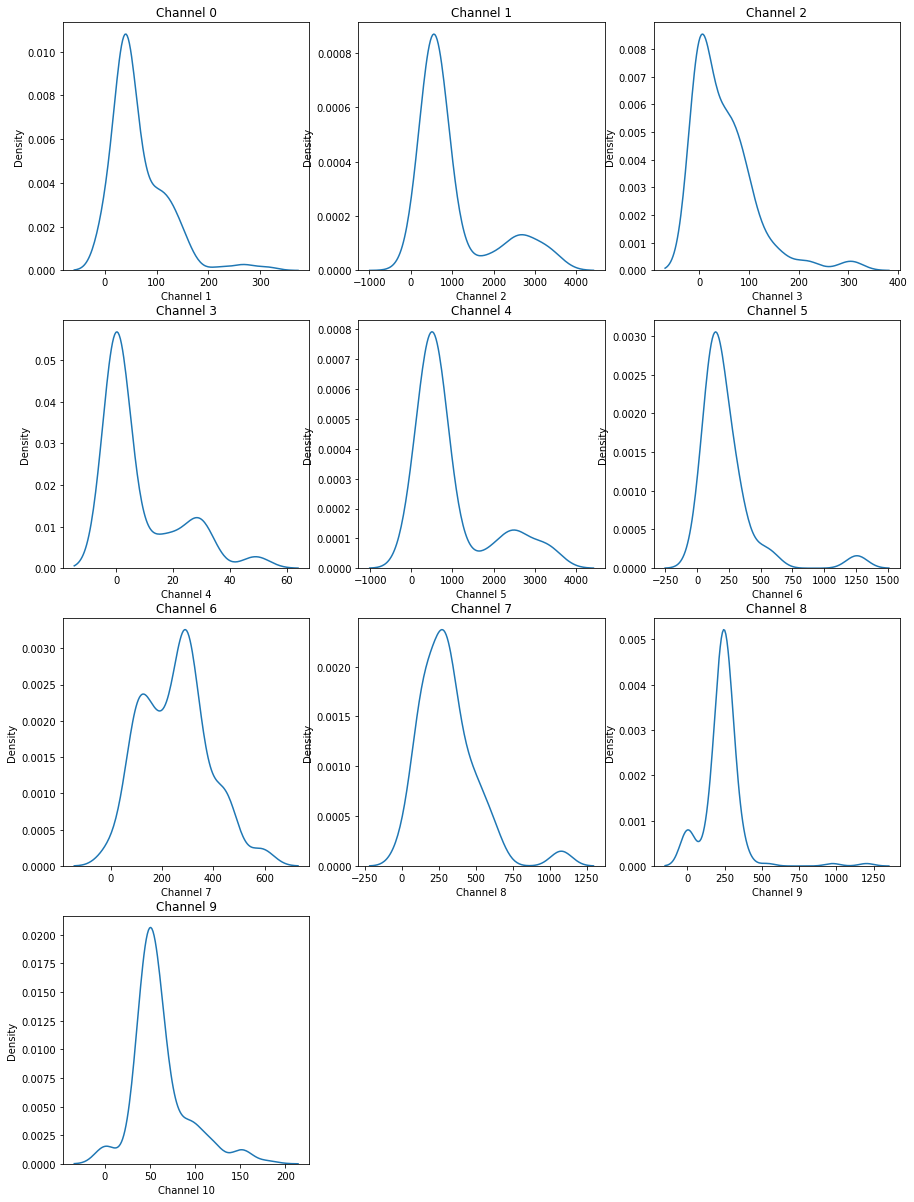

In [37]:
# Probability density distributions for the relevant sensors
plt.figure(figsize = (15, 21))
for i,j in enumerate([0,1,2,3,4,5,6,7,8,9]):
    temp_data = train_data.iloc[:, j]
    plt.subplot(4, 3, i+1)
    sns.kdeplot(temp_data, legend = False)
    plt.title("Channel " + str(j))
plt.show()

In [39]:
# Feature importance
feature_importance = xgbr.feature_importances_
feature_importance.sum()

1.0000001

In [55]:
num_features = feature_importance.shape[0]
num_features

12

In [49]:
# Sort features in descending order
indices = np.argsort(feature_importance)[::-1]

In [56]:
feature_names = {0:'Channel 1', 1:'Channel 2', 2:'Channel 3', 3:'Channel 4', 4:'Channel 5',
                 5:'Channel 6', 6:'Channel 7', 7:'Channel 8', 8:'Channel 9', 9:'Channel 10', 
                 10: 'Sine_Feacyc_week', 11: 'Cosine_Feacyc_Week'}

# Reorder dict by descending feature importance
for key in indices:
    feature_names[key] = feature_names.pop(key)

features = list(feature_names.values())

In [86]:
feature_importance

array([2.4889508e-05, 1.5911456e-02, 2.3868628e-05, 1.0279144e-07,
       5.8650351e-03, 2.4811721e-03, 6.0128770e-03, 2.0649065e-03,
       1.9163316e-02, 9.4844937e-01, 2.7418034e-06, 2.9823926e-07],
      dtype=float32)

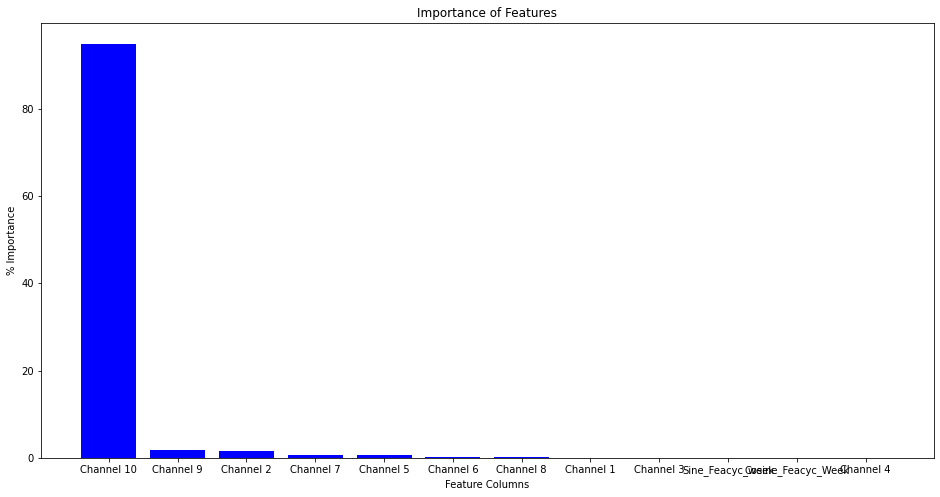

In [60]:
plt.figure(figsize = (16, 8))
plt.title('Importance of Features')

plt.bar(range(num_features), feature_importance[indices] * 100, color = 'blue', align = 'center')
plt.xticks(range(num_features), features)
plt.xlabel('Feature Columns')
plt.ylabel('% Importance')
# plt.xlim(-1, num_features)
plt.show()

In [81]:
''' In the above feature importance chart, Channel 10 has the most influence on the number of transactions. 
    Channels 9 and 2 are of very little significance where as Channels 7, 5, 6, 8, 1, 3, 4 are negligible and carry next to
    no importance. The Sine and Cosine cyclic features are dependant features.'''

' In the above feature importance chart, Channel 10 has the most influence on the number of transactions. \n    Channels 9 and 2 are of very little significance where as Channels 7, 5, 6, 8, 1, 3, 4 are negligible and carry next to\n    no importance. The Sine and Cosine cyclic features are dependant features.'

In [84]:
new_data = train_data.drop(['Channel 1' , 'Channel 3' , 'Channel 4', 'Channel 5', 'Channel 6', 'Channel 7', 'Channel 8', 
                              'Sine_Feacyc_Week', 'Cosine_Feacyc_Week'], axis=1)
new_data

,Channel 2,Channel 9,Channel 10,Transactions
3,670.77,51.0,0.0,0.0
4,746.61,0.0,0.0,0.0
5,597.05,119.0,0.0,0.0
6,485.72,170.0,0.0,120.0
7,531.16,181.0,60.0,149.0
...,...,...,...,...
146,2433.19,0.0,42.0,74.0
147,1895.48,0.0,44.0,69.0
148,1160.86,0.0,16.0,9.0
149,773.49,0.0,0.0,0.0
